**Learning Embedded Stochastic Approximation with Model-Agnostic Meta-Learning** 

Setting up the MAML model based on torchmeta library

In [1]:
import torch
import torchvision
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torchmeta
from torchmeta.modules import (MetaModule, MetaSequential, MetaLinear)

In [2]:
class RegressionNeuralNetwork(MetaModule):
    def __init__(self, in_channels, hidden1_size = 40, hidden2_size = 80):
        super(RegressionNeuralNetwork, self).__init__()
        self.in_channels = in_channels
        self.hidden1_size = hidden1_size 
        self.hidden2_size = hidden2_size 
        
        self.regressor = MetaSequential(
            MetaLinear(in_channels, hidden1_size),
            nn.ReLU(),
            MetaLinear(hidden1_size, hidden2_size),
            nn.ReLU(),
            MetaLinear(hidden2_size, hidden1_size),
            nn.ReLU(),
            MetaLinear(hidden1_size, 1)
        )
        
    def forward(self, inputs, params=None):
        values = self.regressor(inputs, params=self.get_subdict(params, 'regressor'))
        #values = values.view(values.size(0),-1)
        return values
    

Setting up the training function

In [3]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
import logging

from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.gradient_based import gradient_update_parameters

In [4]:
def meta_train(args, metaDataloader):
    model = RegressionNeuralNetwork(args['in_channels'], hidden1_size = args['hidden1_size'],
                                    hidden2_size = args['hidden2_size'])
    model.train()
    meta_optimizer = torch.optim.Adam(model.parameters(), lr=args['beta'])
    loss_record = []
    # training loop 
    for it_outer in range(args['num_it_outer']):
        model.zero_grad()
        
        train_dataloader = metaDataloader['train']
        
        test_dataloader = metaDataloader['test']
        
        outer_loss = torch.tensor(0., dtype=torch.float)
        for task in train_dataloader:
            iterator = iter(train_dataloader[task])
            train_sample = iterator.next()
            # get true h value
            #h_value = torch.tensor(train_sample[:,-1], dtype=torch.float)
            h_value = train_sample[:,-1].clone().detach().to(dtype=torch.float)
            # get input 
            #input_value = torch.tensor(train_sample[:,:-1], dtype=torch.float)
            input_value = train_sample[:,:-1].clone().detach().to(dtype=torch.float)
            # 
            train_h_value = model(input_value)
            inner_loss = F.mse_loss(train_h_value.view(-1,1), h_value.view(-1,1))
            
            model.zero_grad()
            #print('It {}, task {}, Start updating parameters'.format(it_outer, task))
            params = gradient_update_parameters(model, inner_loss, step_size = args['alpha'], 
                                                 first_order=args['first_order'])
            # adaptation 
            # get test sample 
            test_iterator = iter(test_dataloader[task])
            test_sample = test_iterator.next()
            #h_value2 = torch.tensor(test_sample[:,-1], dtype=torch.float)
            h_value2 = test_sample[:,-1].clone().detach().to(dtype=torch.float)
            #test_input_value = torch.tensor(test_sample[:,:-1], dtype=torch.float)
            test_input_value = test_sample[:,:-1].clone().detach().to(dtype=torch.float)
            test_h_value = model(test_input_value, params=params)
            
            outer_loss += F.mse_loss(test_h_value.view(-1,1), h_value2.view(-1,1))
            
        outer_loss.div_(args['num_tasks'])
        
        outer_loss.backward()
        meta_optimizer.step()
        
        loss_record.append(outer_loss.detach())
        if it_outer % 50 == 0:
            print('It {}, outer traning loss: {}'.format(it_outer, outer_loss)) 
    # print the loss plot 
    plt.plot(loss_record)
    plt.title('Outer Training Loss (MSE Loss) in MAML')
    plt.xlabel('Iteration number')
    plt.show()
    
    # save model 
    if args['output_model'] is not None:
        with open(args['output_model'], 'wb') as f:
            state_dict = model.state_dict()
            torch.save(state_dict, f)

In [27]:
def fine_tune(args, model, dataloader, validation_set):
    # set the model to be train mode
    model.train()
    # set the optimizer 
    opt = torch.optim.Adam(model.parameters(), lr=args['learning_rate'])
    # 
    train_it = 0
    loss_record = []
    validation_loss_record = []
    flag_stop = False
    for ep in range(args['epoch']):
        print("Run Epoch {}".format(ep))
        for data in dataloader:
            #input_value = torch.tensor(data[:,:-1], dtype=torch.float)
            input_value = data[:,:-1].clone().detach().to(dtype=torch.float)
            #h_value = torch.tensor(data[:,-1], dtype=torch.float)
            h_value = data[:,-1].clone().detach().to(dtype=torch.float)
            # zero out gradients 
            opt.zero_grad()
            # forward recursion 
            est_h_value = model(input_value)
            # loss 
            loss = F.mse_loss(est_h_value.view(-1,1), h_value.view(-1,1))
            # backward recursion 
            loss.backward()
            # update the weights 
            opt.step()
            # calculate validation loss 
            loss_record.append(loss.detach())
            with torch.no_grad():
                input_value_val = torch.tensor(validation_set[:, :-1], dtype=torch.float)
                h_value_val = torch.tensor(validation_set[:,-1], dtype=torch.float)
                est_h_value_val = model(input_value_val)
                val_loss = F.mse_loss(est_h_value_val.view(-1,1), h_value_val.view(-1,1))
                validation_loss_record.append(val_loss)
            if train_it % 5 == 0:
                print("It {}, L2 training loss: {} ".format(train_it, loss.item()))
                print("It {}, L2 validation loss: {}".format(train_it, val_loss.item()))
            if train_it > args['Max_it']:
                print('Stop fine-tuning')
                flag_stop = True
                break
            train_it += 1
        if flag_stop == True:
            break
    # print the loss plot 
    fig = plt.figure(figsize = (10,5))
    ax1 = plt.subplot(121)
    ax1.plot(loss_record)
    ax1.title.set_text('Training Loss (MSE Loss)')
    ax1.set_xlabel('Iteration Number')
    
    ax2 = plt.subplot(122)
    ax2.plot(validation_loss_record)
    ax2.title.set_text('Validation Loss (MSE Loss)')
    ax2.set_xlabel('Iteration Number')
    plt.show()
    
    # save the model 
    if args['output_model'] is not None:
        with open(args['output_model'], 'wb') as f:
            state_dict = model.state_dict()
            torch.save(state_dict, f)
        print('The model is saved.')

**Meta-Learning baa99 and landS**

Data Preprocessing
Padding Zeros between $x$ and $\omega$. 
The function $h$ is always convex w.r.t. $x$ and continuous w.r.t. $\omega$. 

In [5]:
# load baa99 file 
baa99_data = pd.read_csv('/Users/sonny/Documents/Courses/CSCI566/experiment/training_set/baa99_sample4.csv')
# split the data file 
baa99_train, baa99_val = train_test_split(baa99_data, test_size=0.2)

# load landS file 
landS_data = pd.read_csv('/Users/sonny/Documents/Courses/CSCI566/experiment/training_set/landS_sample4.csv')
# split the data file 
landS_train, landS_val = train_test_split(landS_data, test_size=0.2)


In [6]:
# pad zeros 
# 5 channels for x and 5 channels for omega 
n_x = 5
n_omega = 5

# baa99
baa99_train.to_numpy()
baa99_val.to_numpy()

baa99_train_pad_zero = np.zeros((baa99_train.shape[0],n_x+n_omega+1))
baa99_val_pad_zero = np.zeros((baa99_val.shape[0],n_x+n_omega+1))

baa99_train_pad_zero[:,:2] = baa99_train.to_numpy()[:,:2]
baa99_train_pad_zero[:,n_x:(n_x+2)] = baa99_train.to_numpy()[:,2:4]
baa99_train_pad_zero[:,-1] = baa99_train.to_numpy()[:,-1]

baa99_val_pad_zero[:,:2] = baa99_val.to_numpy()[:,:2]
baa99_val_pad_zero[:,n_x:(n_x+2)] = baa99_val.to_numpy()[:,2:4]
baa99_val_pad_zero[:,-1] = baa99_val.to_numpy()[:,-1]

print(baa99_train_pad_zero[0,:])

[ 54.5887 213.28     0.       0.       0.     113.966   91.1813   0.
   0.       0.     215.756 ]


In [7]:
# landS
landS_train.to_numpy()
landS_val.to_numpy()

landS_train_pad_zero = np.zeros((landS_train.shape[0],n_x+n_omega+1))
landS_val_pad_zero = np.zeros((landS_val.shape[0],n_x+n_omega+1))

landS_train_pad_zero[:,:4] = landS_train.to_numpy()[:,:4]
landS_train_pad_zero[:,n_x] = landS_train.to_numpy()[:,4]
landS_train_pad_zero[:,-1] = landS_train.to_numpy()[:,-1]

landS_val_pad_zero[:,:4] = landS_val.to_numpy()[:,:4]
landS_val_pad_zero[:,n_x] = landS_val.to_numpy()[:,4]
landS_val_pad_zero[:,-1] = landS_val.to_numpy()[:,-1]

In [8]:
# set up data loader 
batch_size = 40
nworkers = 4
baa99_train_data_loader = torch.utils.data.DataLoader(baa99_train_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)
baa99_val_data_loader = torch.utils.data.DataLoader(baa99_val_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)

landS_train_data_loader = torch.utils.data.DataLoader(landS_train_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)
landS_val_data_loader = torch.utils.data.DataLoader(landS_val_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)


In [9]:
 # dictionary for the data loader 
train_data_loader = {}
val_data_loader = {}

tasks = ['baa99', 'landS']
train_data_loader['baa99'] = baa99_train_data_loader
train_data_loader['landS'] = landS_train_data_loader

val_data_loader['baa99'] = baa99_val_data_loader
val_data_loader['landS'] = landS_val_data_loader

meta_data_loader = {}
meta_data_loader['train'] = train_data_loader
meta_data_loader['test'] = val_data_loader # note here test = val 

Setting up model parameters 

In [10]:
model_parameters = {}
model_parameters['in_channels'] = n_x + n_omega
model_parameters['hidden1_size'] = 40
model_parameters['hidden2_size'] = 80
model_parameters['beta'] = 1e-3
model_parameters['alpha'] = 1e-4
model_parameters['first_order'] = False
model_parameters['num_it_outer'] = 1000
model_parameters['num_tasks'] = 2
model_parameters['output_model'] = None

/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/sonny/Documents/Courses/CSCI566/Project/venv_

It 0, traning loss: 829860.375
It 50, traning loss: 580658.25
It 100, traning loss: 481935.21875
It 150, traning loss: 487341.0
It 200, traning loss: 1003085.0625
It 250, traning loss: 772604.0
It 300, traning loss: 685759.875
It 350, traning loss: 509219.9375
It 400, traning loss: 758166.5
It 450, traning loss: 545304.3125
It 500, traning loss: 537428.8125
It 550, traning loss: 351089.21875
It 600, traning loss: 395663.9375
It 650, traning loss: 439625.84375
It 700, traning loss: 264869.25
It 750, traning loss: 404535.15625
It 800, traning loss: 172047.78125
It 850, traning loss: 314938.84375
It 900, traning loss: 111352.8046875
It 950, traning loss: 79267.1484375


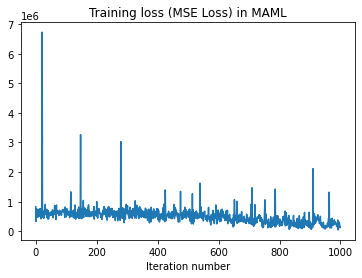

In [11]:
# run the training loop 
meta_train(model_parameters, meta_data_loader)

**Meta-Learning LandS and LandS2**

Then use the MAML model to adapt to landS3

In [6]:
# load landS file 
landS_data = pd.read_csv('/Users/sonny/Documents/Courses/CSCI566/experiment/training_set/landS_sample5.csv')
# split the data file 
landS_train, landS_val = train_test_split(landS_data, test_size=0.2)

# load landS2 file 
landS2_data = pd.read_csv('/Users/sonny/Documents/Courses/CSCI566/experiment/training_set/landS2_sample4.csv')
# split the data file 
landS2_train, landS2_val = train_test_split(landS2_data, test_size=0.2)

# load landS3 file 
landS3_data = pd.read_csv('/Users/sonny/Documents/Courses/CSCI566/experiment/training_set/landS3_sample4.csv')
# split the data file 
landS3_train, landS3_val = train_test_split(landS3_data, test_size=0.2)

Data preprocessing 

Padding zeros to the end of $x$ and $\omega$. 

In [8]:
# pad zeros 
# 5 channels for x and 5 channels for omega 
n_x = 5
n_omega = 5

In [6]:

# landS

landS_train_pad_zero = np.zeros((landS_train.shape[0],n_x+n_omega+1))
landS_val_pad_zero = np.zeros((landS_val.shape[0],n_x+n_omega+1))

landS_train_pad_zero[:,:4] = landS_train.to_numpy()[:,:4]
landS_train_pad_zero[:,n_x] = landS_train.to_numpy()[:,4]
landS_train_pad_zero[:,-1] = landS_train.to_numpy()[:,-1]

landS_val_pad_zero[:,:4] = landS_val.to_numpy()[:,:4]
landS_val_pad_zero[:,n_x] = landS_val.to_numpy()[:,4]
landS_val_pad_zero[:,-1] = landS_val.to_numpy()[:,-1]

In [7]:
# landS2

landS2_train_pad_zero = np.zeros((landS2_train.shape[0],n_x+n_omega+1))
landS2_val_pad_zero = np.zeros((landS2_val.shape[0],n_x+n_omega+1))

landS2_train_pad_zero[:,:4] = landS2_train.to_numpy()[:,:4]
landS2_train_pad_zero[:,n_x : (n_x + 3)] = landS2_train.to_numpy()[:,4:7]
landS2_train_pad_zero[:,-1] = landS2_train.to_numpy()[:,-1]

landS2_val_pad_zero[:,:4] = landS2_val.to_numpy()[:,:4]
landS2_val_pad_zero[:,n_x : (n_x + 3)] = landS2_val.to_numpy()[:,4:7]
landS2_val_pad_zero[:,-1] = landS2_val.to_numpy()[:,-1]

In [9]:
# landS3

landS3_train_pad_zero = np.zeros((landS3_train.shape[0],n_x+n_omega+1))
landS3_val_pad_zero = np.zeros((landS3_val.shape[0],n_x+n_omega+1))

landS3_train_pad_zero[:,:4] = landS3_train.to_numpy()[:,:4]
landS3_train_pad_zero[:,n_x : (n_x + 3)] = landS3_train.to_numpy()[:,4:7]
landS3_train_pad_zero[:,-1] = landS3_train.to_numpy()[:,-1]

landS3_val_pad_zero[:,:4] = landS3_val.to_numpy()[:,:4]
landS3_val_pad_zero[:,n_x : (n_x + 3)] = landS3_val.to_numpy()[:,4:7]
landS3_val_pad_zero[:,-1] = landS3_val.to_numpy()[:,-1]

Skip landS3 for now. 

In [11]:
# set up data loader 
batch_size = 40
nworkers = 4

landS_train_data_loader = torch.utils.data.DataLoader(landS_train_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)
landS_val_data_loader = torch.utils.data.DataLoader(landS_val_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)

landS2_train_data_loader = torch.utils.data.DataLoader(landS2_train_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)
landS2_val_data_loader = torch.utils.data.DataLoader(landS2_val_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)

In [12]:
 # dictionary for the data loader 
train_data_loader = {}
val_data_loader = {}

tasks = ['landS', 'landS2']
train_data_loader['landS'] = landS_train_data_loader
train_data_loader['landS2'] = landS2_train_data_loader

val_data_loader['landS'] = landS_val_data_loader
val_data_loader['landS2'] = landS2_val_data_loader

meta_data_loader = {}
meta_data_loader['train'] = train_data_loader
meta_data_loader['test'] = val_data_loader # note here test = val to follow the notation in MAML example 

Test on model hyperparameters

In [13]:
model_parameters = {}
model_parameters['in_channels'] = n_x + n_omega
model_parameters['hidden1_size'] = 40
model_parameters['hidden2_size'] = 80
model_parameters['beta'] = 1e-3
model_parameters['alpha'] = 1e-4
model_parameters['first_order'] = False
model_parameters['num_it_outer'] = 1000
model_parameters['num_tasks'] = 2
model_parameters['output_model'] = None

/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/sonny/Documents/Courses/CSCI566/Project/venv_

It 0, traning loss: 52421.6484375
It 50, traning loss: 6121.3740234375
It 100, traning loss: 5418.85595703125
It 150, traning loss: 4434.2509765625
It 200, traning loss: 11476.48828125
It 250, traning loss: 5466.86962890625
It 300, traning loss: 4243.67578125
It 350, traning loss: 8119.8720703125
It 400, traning loss: 3354.15087890625
It 450, traning loss: 2608.126220703125
It 500, traning loss: 2434.494140625
It 550, traning loss: 2266.569580078125
It 600, traning loss: 4107.30322265625
It 650, traning loss: 3910.755859375
It 700, traning loss: 2575.302734375
It 750, traning loss: 4269.517578125
It 800, traning loss: 5631.9755859375
It 850, traning loss: 2001.833251953125
It 900, traning loss: 4319.1318359375
It 950, traning loss: 1792.435546875


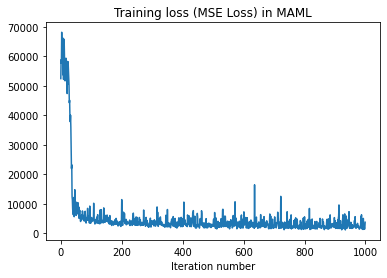

In [14]:
# run the training loop 
meta_train(model_parameters, meta_data_loader)

In [15]:
model_parameters = {}
model_parameters['in_channels'] = n_x + n_omega
model_parameters['hidden1_size'] = 40
model_parameters['hidden2_size'] = 80
model_parameters['beta'] = 1e-4
model_parameters['alpha'] = 1e-4
model_parameters['first_order'] = False
model_parameters['num_it_outer'] = 1000
model_parameters['num_tasks'] = 2
model_parameters['output_model'] = None

/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


It 0, outer traning loss: 61075.25
It 50, outer traning loss: 60144.9140625
It 100, outer traning loss: 62898.6484375
It 150, outer traning loss: 53497.37890625
It 200, outer traning loss: 37636.0546875
It 250, outer traning loss: 7605.619140625
It 300, outer traning loss: 7961.2626953125
It 350, outer traning loss: 8310.2470703125
It 400, outer traning loss: 6597.47900390625
It 450, outer traning loss: 6919.25390625
It 500, outer traning loss: 5213.14208984375
It 550, outer traning loss: 5680.8974609375
It 600, outer traning loss: 5246.904296875
It 650, outer traning loss: 4154.90673828125
It 700, outer traning loss: 3664.897705078125
It 750, outer traning loss: 6217.5283203125
It 800, outer traning loss: 3771.04345703125
It 850, outer traning loss: 7237.251953125
It 900, outer traning loss: 5598.572265625
It 950, outer traning loss: 4533.22607421875


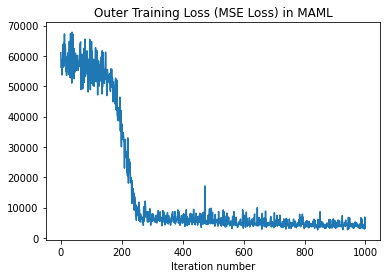

In [20]:
# run the training loop 
meta_train(model_parameters, meta_data_loader)

**Finalize Learning Rate**

$\beta = 10^{-3}$, $\alpha = 10^{-4}$

In [21]:
model_parameters = {}
model_parameters['in_channels'] = n_x + n_omega
model_parameters['hidden1_size'] = 40
model_parameters['hidden2_size'] = 80
model_parameters['beta'] = 1e-3
model_parameters['alpha'] = 1e-4
model_parameters['first_order'] = False
model_parameters['num_it_outer'] = 1000
model_parameters['num_tasks'] = 2
model_parameters['output_model'] = '/Users/sonny/Documents/Courses/CSCI566/experiment/landS_maml_model.pt'

It 0, outer traning loss: 58946.7734375
It 50, outer traning loss: 6068.0029296875
It 100, outer traning loss: 6726.55126953125
It 150, outer traning loss: 3624.95361328125
It 200, outer traning loss: 9410.3505859375
It 250, outer traning loss: 2658.379150390625
It 300, outer traning loss: 3063.94140625
It 350, outer traning loss: 4962.30615234375
It 400, outer traning loss: 3052.87646484375
It 450, outer traning loss: 9292.8701171875
It 500, outer traning loss: 2432.986572265625
It 550, outer traning loss: 2647.772216796875
It 600, outer traning loss: 2586.67041015625
It 650, outer traning loss: 3628.69189453125
It 700, outer traning loss: 2594.49072265625
It 750, outer traning loss: 1995.461669921875
It 800, outer traning loss: 4233.92138671875
It 850, outer traning loss: 4843.8876953125
It 900, outer traning loss: 1938.814453125
It 950, outer traning loss: 2990.563232421875


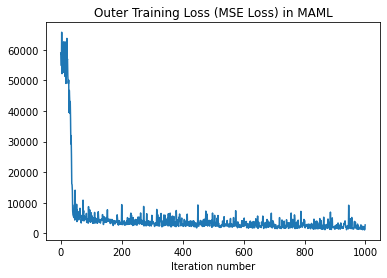

In [24]:
# run the training loop 
meta_train(model_parameters, meta_data_loader)

**Load MAML Model and Fine-tuning**

In [21]:
load_path = '/Users/sonny/Documents/Courses/CSCI566/experiment/landS_maml_model.pt'
maml_model_load = RegressionNeuralNetwork(n_x + n_omega)
maml_model_load.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [22]:
# fine tune the model 
fine_tune_parameter = {}
fine_tune_parameter['learning_rate'] = 1e-4
fine_tune_parameter['Max_it'] = 600
fine_tune_parameter['epoch'] = 20
#fine_tune_parameter['output_model'] = '/Users/sonny/Documents/Courses/CSCI566/experiment/landS_maml_model_adapt.pt'
fine_tune_parameter['output_model'] = None

In [12]:
# build data loader for landS3
batch_size = 40
nworkers = 4

landS3_train_fine_tune, landS3_other_fine_tune = train_test_split(landS3_train, test_size=0.8)


landS3_train_fine_tune_pad_zero = np.zeros((landS3_train_fine_tune.shape[0],n_x+n_omega+1))

landS3_train_fine_tune_pad_zero[:,:4] = landS3_train_fine_tune.to_numpy()[:,:4] # x
landS3_train_fine_tune_pad_zero[:,n_x:(n_x+3)] = landS3_train_fine_tune.to_numpy()[:,4:7] # omega
landS3_train_fine_tune_pad_zero[:,-1] = landS3_train_fine_tune.to_numpy()[:,-1] # h

landS3_train_fine_tune_data_loader = torch.utils.data.DataLoader(landS3_train_fine_tune_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)

In [17]:
print(landS3_train_fine_tune.shape[0])

1600


Run Epoch 0
It 0, L2 training loss: 21959.56640625 
It 0, L2 validation loss: 18624.83984375
It 5, L2 training loss: 15702.953125 
It 5, L2 validation loss: 18512.341796875
It 10, L2 training loss: 17435.369140625 
It 10, L2 validation loss: 18398.095703125
It 15, L2 training loss: 15626.1748046875 
It 15, L2 validation loss: 18281.85546875
It 20, L2 training loss: 18308.431640625 
It 20, L2 validation loss: 18161.548828125
It 25, L2 training loss: 16131.052734375 
It 25, L2 validation loss: 18035.28515625
It 30, L2 training loss: 15701.505859375 
It 30, L2 validation loss: 17907.994140625
It 35, L2 training loss: 18450.466796875 
It 35, L2 validation loss: 17775.767578125
Run Epoch 1
It 40, L2 training loss: 20616.52734375 
It 40, L2 validation loss: 17639.439453125
It 45, L2 training loss: 20408.796875 
It 45, L2 validation loss: 17499.74609375
It 50, L2 training loss: 20138.49609375 
It 50, L2 validation loss: 17355.845703125
It 55, L2 training loss: 12654.009765625 
It 55, L2 valid

It 480, L2 training loss: 1803.119140625 
It 480, L2 validation loss: 1539.6265869140625
It 485, L2 training loss: 1586.2744140625 
It 485, L2 validation loss: 1517.5118408203125
It 490, L2 training loss: 1315.7545166015625 
It 490, L2 validation loss: 1497.4183349609375
It 495, L2 training loss: 1774.846435546875 
It 495, L2 validation loss: 1480.6688232421875
It 500, L2 training loss: 1881.2796630859375 
It 500, L2 validation loss: 1465.1124267578125
It 505, L2 training loss: 1438.485595703125 
It 505, L2 validation loss: 1449.0137939453125
It 510, L2 training loss: 1157.7098388671875 
It 510, L2 validation loss: 1436.60302734375
It 515, L2 training loss: 1507.5938720703125 
It 515, L2 validation loss: 1425.547607421875
Run Epoch 13
It 520, L2 training loss: 1541.2864990234375 
It 520, L2 validation loss: 1417.3018798828125
It 525, L2 training loss: 1607.5867919921875 
It 525, L2 validation loss: 1409.934814453125
It 530, L2 training loss: 1645.0609130859375 
It 530, L2 validation lo

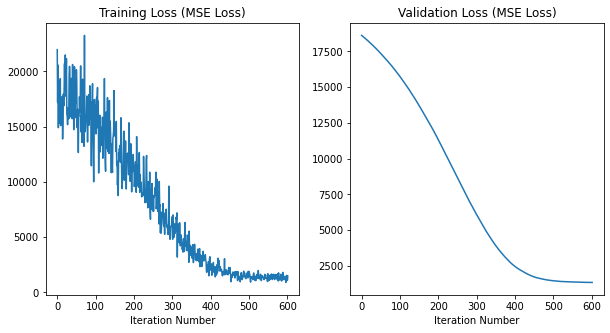

In [23]:
fine_tune(fine_tune_parameter, maml_model_load, landS3_train_fine_tune_data_loader, landS3_val_pad_zero)

Build a counterpart model without using meta-learning 

In [24]:
specialized_model = RegressionNeuralNetwork(n_x + n_omega)

In [25]:
tune_parameter = {}
tune_parameter['learning_rate'] = 1e-4
tune_parameter['Max_it'] = 600
tune_parameter['epoch'] = 20
#fine_tune_parameter['output_model'] = '/Users/sonny/Documents/Courses/CSCI566/experiment/landS_maml_model_adapt.pt'
tune_parameter['output_model'] = None

Run Epoch 0
It 0, L2 training loss: 17629.275390625 
It 0, L2 validation loss: 22021.23828125
It 5, L2 training loss: 23752.130859375 
It 5, L2 validation loss: 22011.16015625
It 10, L2 training loss: 18290.302734375 
It 10, L2 validation loss: 22001.04296875
It 15, L2 training loss: 16801.8359375 
It 15, L2 validation loss: 21990.92578125
It 20, L2 training loss: 18114.419921875 
It 20, L2 validation loss: 21980.751953125
It 25, L2 training loss: 20218.544921875 
It 25, L2 validation loss: 21970.4140625
It 30, L2 training loss: 20681.87109375 
It 30, L2 validation loss: 21959.7265625
It 35, L2 training loss: 23708.40625 
It 35, L2 validation loss: 21948.521484375
Run Epoch 1
It 40, L2 training loss: 17934.306640625 
It 40, L2 validation loss: 21936.765625
It 45, L2 training loss: 23866.966796875 
It 45, L2 validation loss: 21924.775390625
It 50, L2 training loss: 23273.0390625 
It 50, L2 validation loss: 21912.1953125
It 55, L2 training loss: 19749.07421875 
It 55, L2 validation loss:

Run Epoch 12
It 480, L2 training loss: 4057.90380859375 
It 480, L2 validation loss: 4103.44140625
It 485, L2 training loss: 3091.757080078125 
It 485, L2 validation loss: 3911.2314453125
It 490, L2 training loss: 3023.35205078125 
It 490, L2 validation loss: 3736.364013671875
It 495, L2 training loss: 2870.83984375 
It 495, L2 validation loss: 3576.533935546875
It 500, L2 training loss: 3278.380126953125 
It 500, L2 validation loss: 3428.779052734375
It 505, L2 training loss: 2714.63427734375 
It 505, L2 validation loss: 3296.414306640625
It 510, L2 training loss: 3453.180908203125 
It 510, L2 validation loss: 3174.613037109375
It 515, L2 training loss: 3574.71337890625 
It 515, L2 validation loss: 3063.549072265625
Run Epoch 13
It 520, L2 training loss: 3616.862548828125 
It 520, L2 validation loss: 2959.240966796875
It 525, L2 training loss: 3016.32568359375 
It 525, L2 validation loss: 2865.907958984375
It 530, L2 training loss: 2976.055419921875 
It 530, L2 validation loss: 2784.8

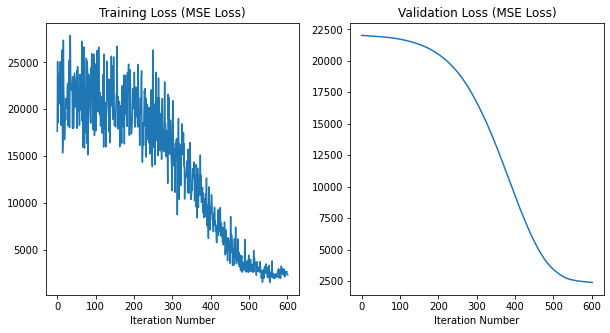

In [26]:
fine_tune(tune_parameter, specialized_model, landS3_train_fine_tune_data_loader, landS3_val_pad_zero)

Finalize the model and save it. 

In [28]:
load_path = '/Users/sonny/Documents/Courses/CSCI566/experiment/landS_maml_model.pt'
maml_model_load2 = RegressionNeuralNetwork(n_x + n_omega)
maml_model_load2.load_state_dict(torch.load(load_path))

<All keys matched successfully>

Run Epoch 0
It 0, L2 training loss: 14910.830078125 
It 0, L2 validation loss: 18624.83984375
It 5, L2 training loss: 16296.0966796875 
It 5, L2 validation loss: 18510.568359375
It 10, L2 training loss: 19512.02734375 
It 10, L2 validation loss: 18394.740234375
It 15, L2 training loss: 20292.6875 
It 15, L2 validation loss: 18275.197265625
It 20, L2 training loss: 18719.56640625 
It 20, L2 validation loss: 18152.400390625
It 25, L2 training loss: 13802.9951171875 
It 25, L2 validation loss: 18027.3984375
It 30, L2 training loss: 17743.400390625 
It 30, L2 validation loss: 17899.177734375
It 35, L2 training loss: 17906.908203125 
It 35, L2 validation loss: 17767.205078125
Run Epoch 1
It 40, L2 training loss: 20298.6171875 
It 40, L2 validation loss: 17632.345703125
It 45, L2 training loss: 17318.5859375 
It 45, L2 validation loss: 17491.98828125
It 50, L2 training loss: 13731.7001953125 
It 50, L2 validation loss: 17348.306640625
It 55, L2 training loss: 16931.474609375 
It 55, L2 valid

It 480, L2 training loss: 1397.863525390625 
It 480, L2 validation loss: 1540.9141845703125
It 485, L2 training loss: 1465.04150390625 
It 485, L2 validation loss: 1515.9940185546875
It 490, L2 training loss: 1222.9298095703125 
It 490, L2 validation loss: 1495.1495361328125
It 495, L2 training loss: 1490.8756103515625 
It 495, L2 validation loss: 1479.22802734375
It 500, L2 training loss: 1605.1583251953125 
It 500, L2 validation loss: 1465.273681640625
It 505, L2 training loss: 1429.05517578125 
It 505, L2 validation loss: 1451.287841796875
It 510, L2 training loss: 1478.890625 
It 510, L2 validation loss: 1438.15625
It 515, L2 training loss: 1483.1175537109375 
It 515, L2 validation loss: 1427.2291259765625
Run Epoch 13
It 520, L2 training loss: 1419.466552734375 
It 520, L2 validation loss: 1418.62158203125
It 525, L2 training loss: 1529.2626953125 
It 525, L2 validation loss: 1409.2781982421875
It 530, L2 training loss: 1274.296142578125 
It 530, L2 validation loss: 1401.23046875


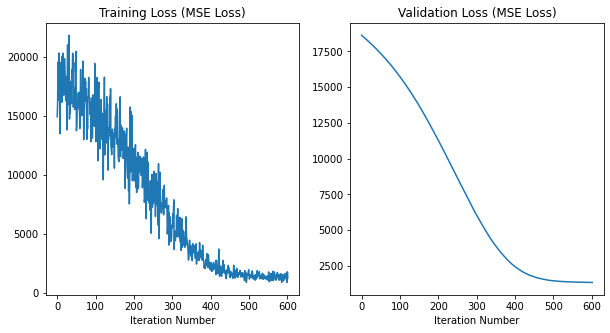

The model is saved.


In [29]:
# fine tune the model 
fine_tune_parameter = {}
fine_tune_parameter['learning_rate'] = 1e-4
fine_tune_parameter['Max_it'] = 600
fine_tune_parameter['epoch'] = 20
fine_tune_parameter['output_model'] = '/Users/sonny/Documents/Courses/CSCI566/experiment/landS3_maml_model_adapt.pt'

fine_tune(fine_tune_parameter, maml_model_load2, landS3_train_fine_tune_data_loader, landS3_val_pad_zero)